# Overview
Best practices for running a supervised model. This is a minimal recreation of scripts from the `dataprep` directory. The purpose is to run these interactively and check for any possible bugs. 

In [21]:
import pandas as pd
import yfinance as yf
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from dataprep.data_pipeline import set_logger, handle_missing_asset, _compute_log_returns, _rolling_zscore, _scale_volume, lag_features
from dataprep.target_generation import binary_threshold
from dataprep.window_dataset import WindowDataset

from torch.utils.data import DataLoader

In [2]:
ASSET = 'T AAPL F GE'.split()
ETF = 'XLE XLC'.split()
MACRO = 'CL=F GC=F ^VIX'.split()

start = '2022-01-01'
end = '2022-12-31'

splits = {
    'train': ['2022-01-11', '2022-06-01'],
    'val':['2022-06-02', '2022-10-01'],
    'test': ['2022-10-02', '2022-12-31']
}

rolling_norm_window = 10
pct = 0.03
horizon = 5

tk_types = {}
for tk in ASSET + ETF + MACRO:
    if tk in ASSET:
        tk_types[tk] = 'asset'
    if tk in ETF:
        tk_types[tk] = 'sector_etf'
    if tk in MACRO:
        tk_types[tk] = 'macro'

# Download raw tickers
Separate the tickers into assets and auxiliary assets. We will be joining them later after some preprocessing.

In [3]:
raw_asset = yf.download(ASSET, start=start, end=end)
raw_aux = yf.download(ETF + MACRO, start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  5 of 5 completed


In [4]:
raw_asset = raw_asset[['Close', 'Volume']]
raw_aux = raw_aux[['Close', 'Volume']]

In [5]:
logger = set_logger('logger.log')
raw_asset = handle_missing_asset(raw_asset, logger, True)

After handling the missing values and joining the assets and auxiliaries we flatten the dataframe

In [6]:
raw = pd.concat([raw_asset, raw_aux], axis=1).sort_index(axis=0)
raw = raw.stack(level=1, future_stack=True)
raw.index.names = ['Datetime', 'Ticker']
raw = raw.sort_index()

Macros that are part of auxiliary don't have volume usually reported so we make their volume nan and later on set their mask to 1 for their feature vector.

In [7]:
# nan all the volumes in macro
for tkr, tk_type in tk_types.items():
    if tk_type == "macro":
        raw.loc[(slice(None), tkr), "Volume"] = np.nan

We are now in a position to add features: 

In [8]:
pred = pd.DataFrame(index=raw.index)
pred["log_ret"] = _compute_log_returns(raw["Close"])
pred["z_log_ret"] = _rolling_zscore(pred["log_ret"], rolling_norm_window)
pred["vol_scaled"] = _scale_volume(raw["Volume"], rolling_norm_window)
pred = pred.groupby(level=1).shift(1)
features = pd.concat([pred, raw['Close']], axis=1)
features['ticker_type'] = features.index.get_level_values('Ticker').map(tk_types)
features['ticker_type'] = features['ticker_type'].astype('category')
features.dropna(subset=['log_ret', 'z_log_ret'], inplace=True)
feature_cols = ["log_ret", "z_log_ret", "vol_scaled"]

In [9]:
# only generate target for assets. The rest will nan after `.join`
df_temp =  features[features['ticker_type'] == 'asset']
label = binary_threshold(df_temp['Close'], pct, horizon, 'up')
assert int(label.isna().sum()) == 0
label = label.dropna().rename('target')
label = pd.DataFrame(label)
# evrything includeing etfs and macros have a label based on out pct, horizon pair

Little visual check to see if the targets are making sense. A better test would be to create an artificial ramp price with flat prices on both sides and see if the target appears in the correct place.

<Axes: xlabel='Datetime'>

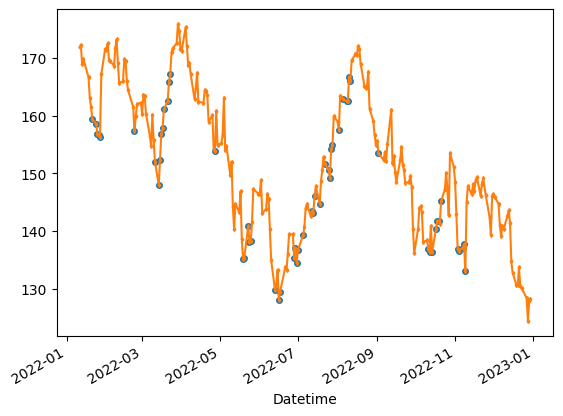

In [10]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()

df = features.xs('AAPL', level=1)['Close']
mask = label.xs('AAPL', level=1)

mask = mask.reindex(df.index, fill_value=0)
df[mask['target'].astype(bool)].plot(ax=ax, marker='o', ls=' ', ms=4)
df.plot(ax=ax, marker='d', ms=2)

In [11]:
# - join feat and label
# - form masks for features
# - if col has nan its corresponding mask is 1, otherwise 0
# - after that, the nan values in col itself become 0.0
data = features.join(label, how='outer')
for col in feature_cols:
    mask_col = f"{col}_mask"
    data[mask_col] = data[col].isna().astype("int8")
    data.fillna({col: 0.0}, inplace=True)

In [12]:
data

log_ret  z_log_ret  vol_scaled        Close ticker_type  \
Datetime   Ticker                                                             
2022-01-11 AAPL    0.000116   0.948045    0.084454   171.843750       asset   
           CL=F   -0.008528  -1.105190    0.000000    81.220001       macro   
           F      -0.024437  -0.750198   -0.382867    19.035610       asset   
           GC=F    0.000779   0.078349    0.000000  1818.599976       macro   
           GE     -0.019720  -1.380482    0.005202    62.335171       asset   
...                     ...        ...         ...          ...         ...   
2022-12-30 GE      0.021483   0.877205   -0.314472    51.533119       asset   
           T       0.012544   0.940759   -0.539708    15.716026       asset   
           XLC     0.027260   1.600712   -0.502914    46.774849  sector_etf   
           XLE     0.010408   0.452448   -0.283803    80.377609  sector_etf   
           ^VIX   -0.032128  -0.621535    0.000000    21.670000       macro   

                   target  log_ret_mask  z_log_ret_mask  vol_scaled_mask  
Datetime   Ticker                                                         
2022-01-11 AAPL       0.0             0               0                0  
           CL=F       NaN             0               0                1  
           F          0.0             0               0                0  
           GC=F       NaN             0               0                1  
           GE         0.0             0               0                0  
...                   ...           ...             ...              ...  
2022-12-30 GE         0.0             0               0                0  
           T          0.0             0               0                0  
           XLC        NaN             0               0                0  
           XLE        NaN             0               0                0  
           ^VIX       NaN             0               0                1  

[2205 rows x 9 columns]

In [13]:
data_train = data.loc[(slice(*splits['train']), slice(None)), :]
data_val = data.loc[(slice(*splits['val']), slice(None)), :]
data_test = data.loc[(slice(*splits['test']), slice(None)), :]

ct = ColumnTransformer(
    transformers=[(f"std_{c}", StandardScaler(), [c]) for c in feature_cols],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)
ct.set_output(transform='pandas')
ct.fit(data_train)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('std_log_ret', StandardScaler(), ['log_ret']),
                                ('std_z_log_ret', StandardScaler(),
                                 ['z_log_ret']),
                                ('std_vol_scaled', StandardScaler(),
                                 ['vol_scaled'])],
                  verbose_feature_names_out=False)

In [14]:
data_train_scaled = ct.transform(data_train)
data_val_scaled = ct.transform(data_val)
data_test_scaled = ct.transform(data_test)

data_train_scaled.to_parquet('train_scaled.parquet', engine='pyarrow', compression='snappy')
data_val_scaled.to_parquet('val_scaled.parquet', engine='pyarrow', compression='snappy')
data_test_scaled.to_parquet('test_scaled.parquet', engine='pyarrow', compression='snappy')

In [15]:
wdset = WindowDataset('train_scaled.parquet', lookback=10, feature_cols=feature_cols)

[Dataset] Entity axis order: ['<ASSET>', 'CL=F', 'GC=F', 'XLC', 'XLE', '^VIX']


In [16]:
b = next(iter(wdset))

In [17]:
b.keys()

dict_keys(['features', 'target', 'ticker', 'date'])

In [18]:
b['features'].shape

torch.Size([10, 6, 6])

In [23]:
dl = DataLoader(wdset, batch_size=4, shuffle=True)

In [25]:
batch = next(iter(dl))

In [26]:
batch.keys()

dict_keys(['features', 'target', 'ticker', 'date'])

In [27]:
batch['features'].shape

torch.Size([4, 10, 6, 6])